In [1]:
#  INSTALL DEPENDENCIES
!pip install torch torchvision matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
noise_dim = 100
image_dim = 28 * 28  # 784
batch_size = 64
lr = 0.0002
num_epochs = 20
save_path = "/content/generated"
os.makedirs(save_path, exist_ok=True)


In [4]:
# DATA LOADING
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.27MB/s]


In [5]:
# GENERATOR NETWORK
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, image_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [6]:
# DISCRIMINATOR NETWORK
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [7]:
# INITIALIZE MODELS AND OPTIMIZERS
G = Generator(noise_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)


In [8]:
# TRAINING LOOP
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(loader):
        real_imgs = real_imgs.view(-1, image_dim).to(device)
        batch_size_current = real_imgs.size(0) # Get the actual batch size

        # === Train Discriminator ===
        z = torch.randn(batch_size_current, noise_dim).to(device)
        fake_imgs = G(z)

        real_labels = torch.ones(batch_size_current, 1).to(device)
        fake_labels = torch.zeros(batch_size_current, 1).to(device)

        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())

        loss_D_real = criterion(D_real, real_labels)
        loss_D_fake = criterion(D_fake, fake_labels)
        loss_D = loss_D_real + loss_D_fake

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # === Train Generator ===
        z = torch.randn(batch_size_current, noise_dim).to(device)
        fake_imgs = G(z)
        output = D(fake_imgs)

        loss_G = criterion(output, real_labels)  # Generator wants D to output 1

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss D: {loss_D.item():.4f}  Loss G: {loss_G.item():.4f}")

    # Save image grid every epoch
    with torch.no_grad():
        z = torch.randn(16, noise_dim).to(device)
        gen_imgs = G(z).view(-1, 1, 28, 28)
        utils.save_image(gen_imgs, f"{save_path}/epoch_{epoch+1}.png", normalize=True)

Epoch [1/20]  Loss D: 1.0544  Loss G: 0.7371
Epoch [2/20]  Loss D: 0.8454  Loss G: 1.1397
Epoch [3/20]  Loss D: 1.0651  Loss G: 1.0006
Epoch [4/20]  Loss D: 0.9948  Loss G: 1.0412
Epoch [5/20]  Loss D: 0.9093  Loss G: 1.0873
Epoch [6/20]  Loss D: 1.6318  Loss G: 0.7425
Epoch [7/20]  Loss D: 0.7384  Loss G: 1.4823
Epoch [8/20]  Loss D: 1.6657  Loss G: 0.6482
Epoch [9/20]  Loss D: 1.1391  Loss G: 1.0216
Epoch [10/20]  Loss D: 0.6162  Loss G: 1.5603
Epoch [11/20]  Loss D: 1.2334  Loss G: 0.9096
Epoch [12/20]  Loss D: 0.5350  Loss G: 1.9323
Epoch [13/20]  Loss D: 0.8439  Loss G: 1.5784
Epoch [14/20]  Loss D: 1.1595  Loss G: 1.2382
Epoch [15/20]  Loss D: 1.3357  Loss G: 1.0305
Epoch [16/20]  Loss D: 1.1241  Loss G: 1.0122
Epoch [17/20]  Loss D: 1.0727  Loss G: 1.1602
Epoch [18/20]  Loss D: 0.6136  Loss G: 1.4985
Epoch [19/20]  Loss D: 1.1960  Loss G: 0.9418
Epoch [20/20]  Loss D: 1.0277  Loss G: 1.1538


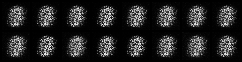

In [9]:
# GENERATED IMAGES FROM LAST EPOCH
import glob
from IPython.display import Image, display

image_files = sorted(glob.glob(save_path + "/*.png"))
display(Image(image_files[-1]))
